In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "/content/Merged_Disasters(2).csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Perform stratified splitting (70% Train, 15% Validation, 15% Test)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Binary_class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Binary_class"], random_state=42)

# Save the split datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Binary_class"].value_counts(),
    "Validation (15%)": val_df["Binary_class"].value_counts(),
    "Test (15%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("split_summary.csv")

# Display summary
print("\nData Split Summary:\n", split_summary)
print("\nData split completed and saved as CSV files.")



Data Split Summary:
 Binary_class      Non-Damage  Damage
Train (70%)            10853    1804
Validation (15%)        2326     386
Test (15%)              2326     387
Total                  15505    2577

Data split completed and saved as CSV files.


Original Train class distribution:
 0    10853
1     1804
Name: count, dtype: int64
Original Validation class distribution:
 0    2326
1     386
Name: count, dtype: int64
Original Test class distribution:
 0    2326
1     387
Name: count, dtype: int64
After SMOTE Train class distribution:
 1    10853
0    10853
Name: count, dtype: int64
Train Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83     10853
           1       0.86      0.76      0.81     10853

    accuracy                           0.82     21706
   macro avg       0.83      0.82      0.82     21706
weighted avg       0.83      0.82      0.82     21706

Train Accuracy: 0.8208
Train ROC-AUC: 0.9020


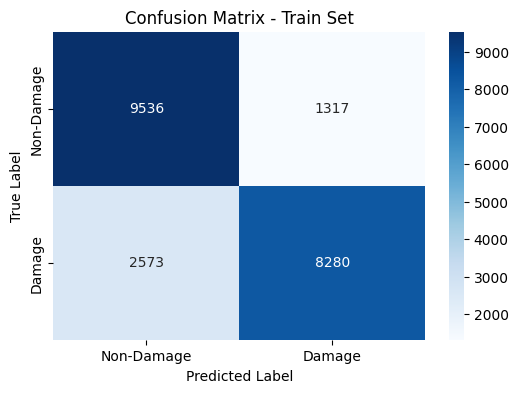

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Paths to the split data stored in Colab workspace
train_path = "/content/train_data.csv"
val_path = "/content/val_data.csv"
test_path = "/content/test_data.csv"

# Load the data
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Standardize labels
label_map = {'damage': 1, 'non-damage': 0}
train_df['Binary_class'] = train_df['Binary_class'].str.strip().str.lower().map(label_map)
val_df['Binary_class'] = val_df['Binary_class'].str.strip().str.lower().map(label_map)
test_df['Binary_class'] = test_df['Binary_class'].str.strip().str.lower().map(label_map)

# Fill missing values in "Processed_data" column
train_df['Processed_data'] = train_df['Processed_data'].fillna("")
val_df['Processed_data'] = val_df['Processed_data'].fillna("")
test_df['Processed_data'] = test_df['Processed_data'].fillna("")

# TF-IDF Feature Extraction
# Using max_features=5000 to limit the number of features
# Removing English stop words and using n-grams (1,2) for better text representation
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['Processed_data'])
X_val = vectorizer.transform(val_df['Processed_data'])
X_test = vectorizer.transform(test_df['Processed_data'])

# Convert labels to NumPy arrays
y_train = train_df['Binary_class'].values
y_val = val_df['Binary_class'].values
y_test = test_df['Binary_class'].values

# Display class distribution before SMOTE
print("Original Train class distribution:\n", pd.Series(y_train).value_counts())
print("Original Validation class distribution:\n", pd.Series(y_val).value_counts())
print("Original Test class distribution:\n", pd.Series(y_test).value_counts())

# Apply SMOTE to balance classes
# Using sampling_strategy=1 to balance both classes equally
# k_neighbors=3 means each synthetic sample is created using 3 nearest neighbors
# random_state=42 ensures reproducibility of results
smote = SMOTE(sampling_strategy=1, k_neighbors=3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display class distribution after SMOTE
print("After SMOTE Train class distribution:\n", pd.Series(y_train_smote).value_counts())

# Train Random Forest on SMOTE-balanced data with modified parameters
# Reduced n_estimators to 80 for efficiency
# Limited max_depth to 15 to prevent overfitting
# Increased min_samples_split to 10 and min_samples_leaf to 5 for better generalization
# random_state=42 ensures reproducibility of results
class_weight_dict = "balanced"
rf_model = RandomForestClassifier(
    n_estimators=80,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight=class_weight_dict,
    random_state=42
)
rf_model.fit(X_train_smote, y_train_smote)

# Evaluate on Train Set
y_train_pred = rf_model.predict(X_train_smote)
y_train_proba = rf_model.predict_proba(X_train_smote)[:, 1]
accuracy_train = accuracy_score(y_train_smote, y_train_pred)
roc_auc_train = roc_auc_score(y_train_smote, y_train_proba)
classification_rep_train = classification_report(y_train_smote, y_train_pred)

print("Train Classification Report:")
print(classification_rep_train)
print(f'Train Accuracy: {accuracy_train:.4f}')
print(f'Train ROC-AUC: {roc_auc_train:.4f}')

# Confusion Matrix for Train Set
cm_train = confusion_matrix(y_train_smote, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Damage', 'Damage'], yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Train Set")
plt.show()
